# Introduction

Deep learning (also known as deep structured learning or differential programming) is part of a broader family of machine learning methods based on artificial neural networks with representation learning. Learning can be supervised, semi-supervised or unsupervised.
Deep learning architectures such as deep neural networks, deep belief networks, recurrent neural networks and convolutional neural networks have been applied to fields including computer vision, speech recognition, natural language processing, audio recognition, social network filtering, machine translation, bioinformatics, drug design, medical image analysis, material inspection and board game programs, where they have produced results comparable to and in some cases surpassing human expert performance.

A Convolutional Neural Network (ConvNet/CNN) is a Deep Learning algorithm which can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image and be able to differentiate one from the other. The pre-processing required in a ConvNet is much lower as compared to other classification algorithms. While in primitive methods filters are hand-engineered, with enough training, ConvNets have the ability to learn these filters/characteristics.
The architecture of a ConvNet is analogous to that of the connectivity pattern of Neurons in the Human Brain and was inspired by the organization of the Visual Cortex. Individual neurons respond to stimuli only in a restricted region of the visual field known as the Receptive Field. A collection of such fields overlap to cover the entire visual area.


The primary purpose of this notebook is to perform Image classification from a public dataset called Flower Recognition dataset that has more than 4000 images of flowers of 5 different categories - Daisies, Dandelions, roses, sunflowers and tulips. To perform our image classification we use a Convolutional Neural network after preprocessing the image data to generate accurate results. The [dataset](https://www.kaggle.com/alxmamaev/flowers-recognition) contains 4242 images of flowers. The data collection is based on the data flicr, google images, yandex images. The pictures are divided into five classes: daisy, tulip, rose, sunflower, dandelion. For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels. Photos are not reduced to a single size, they have different proportions!

# Part A - Deep Learning model (40 points)

Importing the libraries needed to process our images and run the algorithm that can classify the images for us

In [230]:
import numpy as np 
import pandas as pd

import os
print(os.listdir(r"C:\Users\krish\Desktop\ADS\Assignment-3\flowers-recognition"))
from imageio import imread
import PIL
from skimage.transform import resize
from skimage import color
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Convolution2D,BatchNormalization,Flatten,Dense,Dropout,MaxPooling2D
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

['flowers']


In the below code, we store the path to our directory in a variable called dirList. It is important to note that dirList does not contain images directly, rather it has the folders that contain the images. The folders are rightfully named for the flowers we want to classify the images into. The code loops through the folders first and then loops through the images in the folder to resize the images for better classification as some images may vary in size and it is always good practice to resize them and establish a base size to be fed into our algorithm.

In [231]:
dirList=os.listdir(r'C:\Users\krish\Desktop\ADS\Assignment-3\flowers-recognition\flowers/')
imageData=[]
imageLabel=[]
validExtensionsList=['jpg','tif','png','bmp']
for d in dirList:
    print('Processing...',d)
    for f in os.listdir(r'C:\Users\krish\Desktop\ADS\Assignment-3\flowers-recognition\flowers/'+d):
        ext=f.split('.')[-1]
        if ext in validExtensionsList:
            data=imread(r'C:\Users\krish\Desktop\ADS\Assignment-3\flowers-recognition\flowers/'+d+'/'+f)
            #color.rgb2gray(imread('../input/flowers/flowers/'+d+'/'+f))
            resized_data=resize(data,(100,100))
            imageData.append(resized_data)
            imageLabel.append(d)
        else:
            pass
print('DONE!')

Processing... daisy
Processing... dandelion
Processing... flowers
Processing... rose
Processing... sunflower
Processing... tulip
DONE!


The below code checks the shape of the image data and the label data accompanying it. We see that there are a total of 4323 images and labels in our dataset and after resizing the image, the shape is 100 x 100 as seen from the output of the code. Since the images we have are RGB images, it's channel value is 3. We see an image whereas the computer sees an array of pixels of the size 100 x 100 x 3 where 100 is width, next 100 is height and 3 is RGB channel values. In general, the convolutions layers operate on 3D tensors, called feature maps, with two spatial axes of height and width, as well as a channel axis also called depth. For an RGB color image, the dimension of the depth axis is 3, because the image has three channels: red, green and blue. For a black and white image, such as the MNIST digits, the depth axis dimension is 1 (gray level).

In [232]:
np.shape(imageData),np.shape(imageLabel)

((4323, 100, 100, 3), (4323,))

The reshaping and labeling worked properly as we picked an image at random and printed its label which came out clearly.

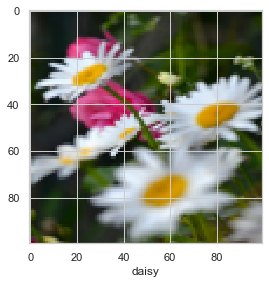

In [233]:
idx=np.random.randint(len(imageData))
plt.imshow(imageData[idx])
plt.xlabel(imageLabel[idx])
plt.show()

In [234]:
X=np.array(imageData)
X=X.reshape(X.shape[0],X.shape[1],X.shape[2],3)
y=np.array(imageLabel)
num_classes=len(set(y))
le=LabelEncoder()
y=le.fit_transform(y)
y=to_categorical(num_classes=num_classes,y=y)
input_shape=(X.shape[1],X.shape[2],X.shape[3])

We currently have 5 classes that we can categorize our images into
Daisy
Dandelion
Rose
Sunflower
Tulip
There are a total of 4323 images of these flowers with the size of 100 x 100.

Here we convert the class labels into one-hot encoding vectors. In one-hot encoding, we convert the categorical data into a vector of numbers. The reason why we convert the categorical data in one hot encoding is that machine learning algorithms cannot work with categorical data directly. You generate one boolean column for each category or class. Only one of these columns could take on the value 1 for each sample. Hence, the term one-hot encoding.

In [235]:
np.shape(X),np.shape(y)

((4323, 100, 100, 3), (4323, 5))

After data preprocessing, we make a model for classifying our data.

##### Convolution Layer
The convolution layer computes the output of neurons that are connected to local regions or receptive fields in the input, each computing a dot product between their weights and a small receptive field to which they are connected to in the input volume. Each computation leads to extraction of a feature map from the input image. 

##### Maxpooling Layer
After the convolution layer comes the pooling layer, where the spatial size of the convoluted features will be attempted to be reduced. The reduction in complexity, sometimes known as dimensionality reduction will decrease the computational cost of performing analysis on the data set, allowing the method to be more robust. In this layer, a kernel once again passes over all subsets of pixels of the image. There are two types of pooling kernels which are commonly used. The first one is Max Pooling, which retains the maximum value of the subset. The alternative kernel is average pooling. Here we use a 2x2 matrix to pass over all the pixels in the image. 

##### Flatten
We have to flatten the 3D tensor to 1D vector before applying it to softmax. The flattening is done by changing the matrix of pixels into a vector of pixels, which can then be used for the neural net model.

##### Dense Layer
A dense layer is the implementation of the equation output = activation(dot(input, kernel) + bias). This means that we are taking the dot product between our input tensor and whatever the weight kernel matrix is featured in our dense layer. Then, we add a bias vector (if we want to have a bias) and take an element-wise activation of the output values (some sort of function, linear or, more often, non-linear!).The units are the most basic parameter to understand. This parameter is a positive integer that denotes the output size of the layer. It’s the most important parameter we can set for this layer. The unit parameter actually dictates the size of the weight matrix and bias vector (the bias vector will be the same size, but the weight matrix will be calculated based on the size of the input data so that the dot product will produce data that is of output size, units). Here unit = 1000 then 500 and then 5
Activation sets the element-wise activation function to be used in the dense layer. We use Relu here

##### Softmax
A Softmax function is a type of squashing function. Squashing functions limit the output of the function into the range 0 to 1. This allows the output to be interpreted directly as a probability. Similarly, softmax functions are multi-class sigmoids, meaning they are used in determining probability of multiple classes at once. Since the outputs of a softmax function can be interpreted as a probability (i.e.they must sum to 1), a softmax layer is typically the final layer used in neural network functions. 


In [236]:
def createCNNModel():
    model=Sequential()
    model.add(Convolution2D(32,5,padding = 'same',input_shape=input_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2),padding='same')) 
    model.add(Convolution2D(64,3,input_shape=input_shape,padding = 'same',activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2),strides = (2,2),padding='same'))
    model.add(Convolution2D(96,3,padding = 'same',input_shape=input_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2),strides = (2,2),padding='same'))
    model.add(Convolution2D(96,3,padding = 'same',input_shape=input_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2),strides = (2,2),padding='same'))
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(Dense(num_classes,activation='softmax'))
    return model


In [237]:
model=createCNNModel()
model.summary()


Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_104 (Conv2D)          (None, 100, 100, 32)      2432      
_________________________________________________________________
max_pooling2d_91 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_92 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 25, 25, 96)        55392     
_________________________________________________________________
max_pooling2d_93 (MaxPooling (None, 13, 13, 96)        0         
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 13, 13, 96)      

In [132]:
batch_size=128
epochs=50

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

Then we divide our dataset into 3 parts respectively which are train, test and validation sets.
The size of the training set is 2766 images, test set is 865 images (which is 20% of the dataset initially divided) and the validation set comprises of 692 images(which is 20% of the training set initially divided)

In [238]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
np.shape(X_train),np.shape(y_train),np.shape(X_test),np.shape(y_test),np.shape(X_val),np.shape(y_val)

((2766, 100, 100, 3),
 (2766, 5),
 (865, 100, 100, 3),
 (865, 5),
 (692, 100, 100, 3),
 (692, 5))

In [239]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

Using little data is possible when the image is preprocessing with Keras ImageDataGenerator class. Тhis class can create a number of random transformations, which helps to increase the number of images when it is needed.
from keras.preprocess. We set the rotation range to 20 which is used for random rotations in the range from 0 to 180. We set the width_shift_range as 0.2 which is shown in fraction of total width, used for random horizontal shifts. We set the width_shift_range as 0.2 which is the same as width_shift_range, but with height. And we set the horizontal_flip to True and it is used for randomly flipping inputs horizontally. All this is done to preprocess our images and make the training of our model better. 



To make sure that our model gives us the best results, we set epochs = 50 as an arbitrary value so that our model can reiterate and get proper weights as needed. We also use the Adam optimizer which is the standard optimizer for neural networks. Adam is an optimization algorithm that can be used instead of the classical stochastic gradient descent procedure to update network weights iterative based in training data. We also use the categorial crossentropy as our loss function.

In [241]:
batch_size=128
epochs=50
from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)
model.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [135]:
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [242]:
History = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size)
# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/50
21/21 [==============================] - 83s 4s/step - loss: 0.4545 - accuracy: 0.8024 - val_loss: 0.4259 - val_accuracy: 0.8014
Epoch 2/50
21/21 [==============================] - 85s 4s/step - loss: 0.4018 - accuracy: 0.8111 - val_loss: 0.3772 - val_accuracy: 0.8277
Epoch 3/50
21/21 [==============================] - 87s 4s/step - loss: 0.3756 - accuracy: 0.8301 - val_loss: 0.3434 - val_accuracy: 0.8572
Epoch 4/50
21/21 [==============================] - 84s 4s/step - loss: 0.3404 - accuracy: 0.8501 - val_loss: 0.3329 - val_accuracy: 0.8517
Epoch 5/50
21/21 [==============================] - 83s 4s/step - loss: 0.3304 - accuracy: 0.8560 - val_loss: 0.3391 - val_accuracy: 0.8569
Epoch 6/50
21/21 [==============================] - 85s 4s/step - loss: 0.3198 - accuracy: 0.8607 - val_loss: 0.3107 - val_accuracy: 0.8671
Epoch 7/50
21/21 [==============================] - 81s 4s/step - loss: 0.3143 - accuracy: 0.8620 - val_loss: 0.2913 - val_accuracy: 0.8783
Epoch 8/50
21/21 [==

In [243]:
model.evaluate(X_test,y_test)

865/865 [==============================] - 8s 10ms/step


[0.27797621324688004, 0.9047399163246155]

In [244]:
y_pred=model.predict(X_test)
y_pred =(y_pred>0.5)

After evaluating our model we get a loss of 0.277 and an accuracy score of 0.904 which is loosely 90.4%

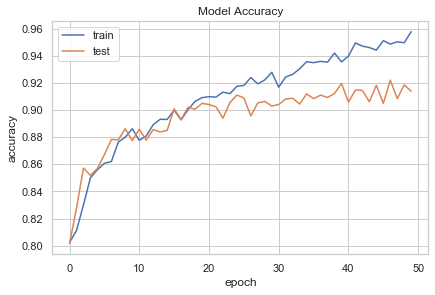

In [245]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

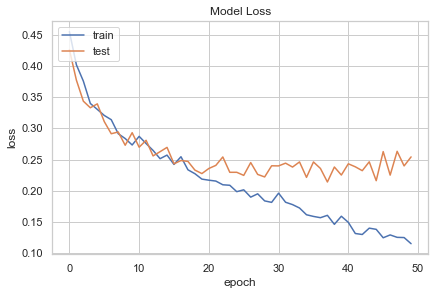

In [246]:
# summarize history for loss
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Classification report will help us in identifying the misclassified classes in more detail. We will be able to observe for which class the model performed bad out of the given ten classes.

In [227]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.88      0.77      0.82       145
     Class 1       0.91      0.75      0.83       216
     Class 2       0.66      0.73      0.69       156
     Class 3       0.81      0.87      0.84       151
     Class 4       0.82      0.71      0.76       197

   micro avg       0.81      0.76      0.79       865
   macro avg       0.82      0.77      0.79       865
weighted avg       0.82      0.76      0.79       865
 samples avg       0.76      0.76      0.76       865



Finally we can see that the test loss and accuracy are in sync with the training loss and training accuracy. Even though the validation loss and accuracy line are not linear, but it shows that the model is not overfitting: the validation loss is decreasing and not increasing, and there is not much gap between training and validation accuracy.

From the classification report we can see from the precision and recall score that the model does relatively well for almost all classes except for Class 2 which has a 0.66 precision score. From the model we have built above, we can predict the species of a flower with a 78% accuracy. 

# Part B - Activation function (10 points)


We are going to use two different widely known Activation functions - tanh and Sigmoid

Activation functions are really important for a Neural Network to learn and make sense of something really complicated and Non-linear complex functional mappings between the inputs and response variable.They introduce non-linear properties to our Network.Their main purpose is to convert a input signal of a node in a NN to an output signal. That output signal now is used as a input in the next layer in the stack.

Tanh — Hyperbolic tangent - It’s mathamatical formula is f(x) = 1 — exp(-2x) / 1 + exp(-2x). Now it’s output is zero centered because its range in between -1 to 1 i.e -1 < output < 1 . Hence optimization is easier in this method hence in practice it is always preferred over Sigmoid function . But still it suffers from Vanishing gradient problem.

Sigmoid - It is a activation function of form f(x) = 1 / 1 + exp(-x) . Its Range is between 0 and 1. It is a S — shaped curve. It is easy to understand and apply but it has major reasons which have made it fall out of popularity



### Using TanH and then evaluating the results 

In [157]:
def createCNNModel():
    model=Sequential()
    model.add(Convolution2D(32,5,padding = 'same',input_shape=input_shape,activation='tanh'))
    model.add(MaxPool2D(pool_size=(2,2),padding='same')) 
    model.add(Convolution2D(64,3,input_shape=input_shape,padding = 'same',activation='tanh'))
    model.add(MaxPool2D(pool_size=(2,2),strides = (2,2),padding='same'))
    model.add(Convolution2D(96,3,padding = 'same',input_shape=input_shape,activation='tanh'))
    model.add(MaxPool2D(pool_size=(2,2),strides = (2,2),padding='same'))
    model.add(Convolution2D(96,3,padding = 'same',input_shape=input_shape,activation='tanh'))
    model.add(MaxPool2D(pool_size=(2,2),strides = (2,2),padding='same'))
    model.add(Flatten())
    model.add(Dense(512,activation='tanh'))
    model.add(Dense(num_classes,activation='softmax'))
    return model

In [158]:
model=createCNNModel()
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_64 (Conv2D)           (None, 100, 100, 32)      2432      
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 25, 25, 96)        55392     
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 13, 13, 96)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 13, 13, 96)      

In [161]:
batch_size=128
epochs=10
from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [162]:
History = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size)
# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/10
21/21 [==============================] - 70s 3s/step - loss: 2.0277 - accuracy: 0.3255 - val_loss: 1.3939 - val_accuracy: 0.4249
Epoch 2/10
21/21 [==============================] - 68s 3s/step - loss: 1.3163 - accuracy: 0.4722 - val_loss: 1.1678 - val_accuracy: 0.5376
Epoch 3/10
21/21 [==============================] - 70s 3s/step - loss: 1.2144 - accuracy: 0.5004 - val_loss: 1.1942 - val_accuracy: 0.5173
Epoch 4/10
21/21 [==============================] - 71s 3s/step - loss: 1.1547 - accuracy: 0.5342 - val_loss: 1.0642 - val_accuracy: 0.5896
Epoch 5/10
21/21 [==============================] - 67s 3s/step - loss: 1.0977 - accuracy: 0.5723 - val_loss: 1.0265 - val_accuracy: 0.5983
Epoch 6/10
21/21 [==============================] - 69s 3s/step - loss: 1.0492 - accuracy: 0.5956 - val_loss: 0.9977 - val_accuracy: 0.5925
Epoch 7/10
21/21 [==============================] - 68s 3s/step - loss: 1.0327 - accuracy: 0.5974 - val_loss: 0.9993 - val_accuracy: 0.5867
Epoch 8/10
21/21 [==

In [163]:
model.evaluate(X_test,y_test)

865/865 [==============================] - 7s 8ms/step


[0.9195387894018537, 0.6520231366157532]

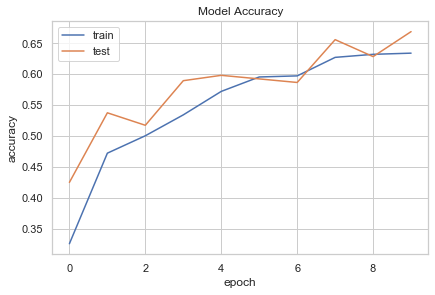

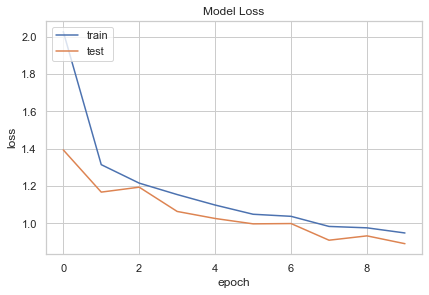

In [164]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



For this section we used the TanH activation function with the same model otherwise and using 10 epochs due to computation and time constraints. We see that the loss and accuracy is 0.91 and 0.65 effectively which means that the model massively overfitted the data and did worse than our baseline model by a lot. However we can see that the test loss and test accuracy both are in sync with the training loss and training accuracy. It is possible that with more iterations, the model has good probability to learn with better results



### Using Sigmoid Activation function now

In [165]:
def createCNNModel():
    model=Sequential()
    model.add(Convolution2D(32,5,padding = 'same',input_shape=input_shape,activation='sigmoid'))
    model.add(MaxPool2D(pool_size=(2,2),padding='same')) 
    model.add(Convolution2D(64,3,input_shape=input_shape,padding = 'same',activation='sigmoid'))
    model.add(MaxPool2D(pool_size=(2,2),strides = (2,2),padding='same'))
    model.add(Convolution2D(96,3,padding = 'same',input_shape=input_shape,activation='sigmoid'))
    model.add(MaxPool2D(pool_size=(2,2),strides = (2,2),padding='same'))
    model.add(Convolution2D(96,3,padding = 'same',input_shape=input_shape,activation='sigmoid'))
    model.add(MaxPool2D(pool_size=(2,2),strides = (2,2),padding='same'))
    model.add(Flatten())
    model.add(Dense(512,activation='sigmoid'))
    model.add(Dense(num_classes,activation='softmax'))
    return model

In [166]:
model=createCNNModel()
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_68 (Conv2D)           (None, 100, 100, 32)      2432      
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 25, 25, 96)        55392     
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 13, 13, 96)        0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 13, 13, 96)      

In [167]:
batch_size=128
epochs=10
from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [168]:
History = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size)
# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/10
21/21 [==============================] - 59s 3s/step - loss: 2.4273 - accuracy: 0.2024 - val_loss: 1.6590 - val_accuracy: 0.1980
Epoch 2/10
21/21 [==============================] - 60s 3s/step - loss: 1.6311 - accuracy: 0.2373 - val_loss: 1.6125 - val_accuracy: 0.2153
Epoch 3/10
21/21 [==============================] - 61s 3s/step - loss: 1.6062 - accuracy: 0.2358 - val_loss: 1.6175 - val_accuracy: 0.2413
Epoch 4/10
21/21 [==============================] - 60s 3s/step - loss: 1.6071 - accuracy: 0.2274 - val_loss: 1.6080 - val_accuracy: 0.2413
Epoch 5/10
21/21 [==============================] - 60s 3s/step - loss: 1.6013 - accuracy: 0.2426 - val_loss: 1.6053 - val_accuracy: 0.2413
Epoch 6/10
21/21 [==============================] - 63s 3s/step - loss: 1.6102 - accuracy: 0.2277 - val_loss: 1.6194 - val_accuracy: 0.2153
Epoch 7/10
21/21 [==============================] - 59s 3s/step - loss: 1.6075 - accuracy: 0.2411 - val_loss: 1.6166 - val_accuracy: 0.2153
Epoch 8/10
21/21 [==

In [169]:
model.evaluate(X_test,y_test)

865/865 [==============================] - 6s 7ms/step


[1.6035003637302818, 0.24971097707748413]

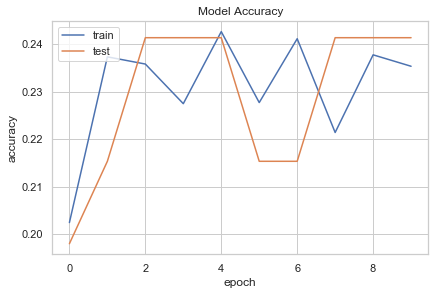

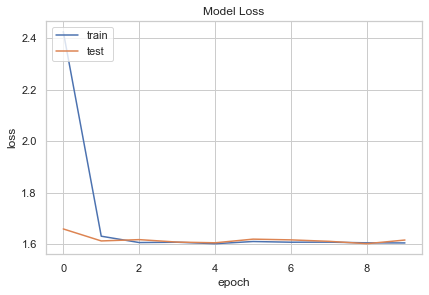

In [170]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



For this section we used the Sigmoid activation function with the same model otherwise and using 10 epochs due to computation and time constraints. We see that the loss and accuracy is 1.063 and 0.249 effectively which means that the model not only overfitted the data massively but also that with more epochs, its performance didn't necessarily improve rather it did worse on both the training and test losses and accuracy.



# Part C - Cost function (10 points)

Neural network models learn a mapping from inputs to outputs from examples and the choice of loss function must match the framing of the specific predictive modeling problem, such as classification or regression. Further, the configuration of the output layer must also be appropriate for the chosen loss function.

Our problem is a multi class classification problem so the loss functions that we have chosen to test are Kullback Leibler Divergence Loss and the Sparse Multiclass Cross-Entropy Loss. We have already used the Multi-Class Cross-Entropy Loss function for our baseline model


In [171]:
def createCNNModel():
    model=Sequential()
    model.add(Convolution2D(32,5,padding = 'same',input_shape=input_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2),padding='same')) 
    model.add(Convolution2D(64,3,input_shape=input_shape,padding = 'same',activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2),strides = (2,2),padding='same'))
    model.add(Convolution2D(96,3,padding = 'same',input_shape=input_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2),strides = (2,2),padding='same'))
    model.add(Convolution2D(96,3,padding = 'same',input_shape=input_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2),strides = (2,2),padding='same'))
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(Dense(num_classes,activation='softmax'))
    return model


In [172]:
model=createCNNModel()
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 100, 100, 32)      2432      
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 25, 25, 96)        55392     
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 13, 13, 96)        0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 13, 13, 96)      

### Using the Kullback Leibler Divergence Loss function.

In [173]:
batch_size=128
epochs=10
from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)
model.compile(optimizer=Adam(lr=0.001),loss='kullback_leibler_divergence',metrics=['accuracy'])

In [174]:
History = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size)
# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/10
21/21 [==============================] - 59s 3s/step - loss: 1.5645 - accuracy: 0.2926 - val_loss: 1.4404 - val_accuracy: 0.3540
Epoch 2/10
21/21 [==============================] - 59s 3s/step - loss: 1.2659 - accuracy: 0.4458 - val_loss: 1.2374 - val_accuracy: 0.5303
Epoch 3/10
21/21 [==============================] - 60s 3s/step - loss: 1.1522 - accuracy: 0.5155 - val_loss: 1.0961 - val_accuracy: 0.5650
Epoch 4/10
21/21 [==============================] - 59s 3s/step - loss: 1.0467 - accuracy: 0.5679 - val_loss: 0.9688 - val_accuracy: 0.6373
Epoch 5/10
21/21 [==============================] - 59s 3s/step - loss: 0.9667 - accuracy: 0.6224 - val_loss: 0.8914 - val_accuracy: 0.6488
Epoch 6/10
21/21 [==============================] - 58s 3s/step - loss: 0.9455 - accuracy: 0.6272 - val_loss: 0.9028 - val_accuracy: 0.6503
Epoch 7/10
21/21 [==============================] - 56s 3s/step - loss: 0.8940 - accuracy: 0.6515 - val_loss: 0.8678 - val_accuracy: 0.6590
Epoch 8/10
21/21 [==

In [175]:
model.evaluate(X_test,y_test)

865/865 [==============================] - 6s 7ms/step


[0.8996333651632242, 0.6520231366157532]

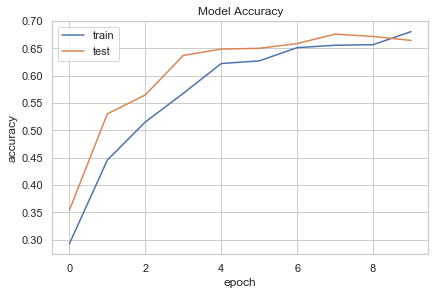

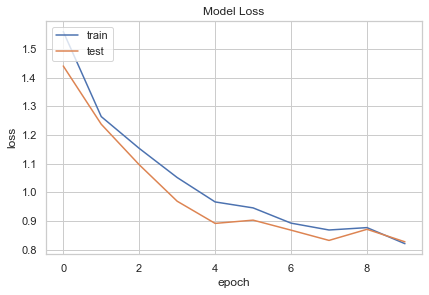

In [176]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Kullback Leibler Divergence, or KL Divergence for short, is a measure of how one probability distribution differs from a baseline distribution. A KL divergence loss of 0 suggests the distributions are identical. In practice, the behavior of KL Divergence is very similar to cross-entropy. It calculates how much information is lost (in terms of bits) if the predicted probability distribution is used to approximate the desired target probability distribution.
With the above model, we got a loss score of 0.899 and accuracy score of 0.652 which means that using the kullback leibler divergence loss function did a worse job than our baseline model

### Using the Sparse Multiclass Cross-Entropy Loss function

In [190]:
def createCNNModel():
    model=Sequential()
    model.add(Convolution2D(32,5,padding = 'same',input_shape=input_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2),padding='same')) 
    model.add(Convolution2D(64,3,input_shape=input_shape,padding = 'same',activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2),strides = (2,2),padding='same'))
    model.add(Convolution2D(96,3,padding = 'same',input_shape=input_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2),strides = (2,2),padding='same'))
    model.add(Convolution2D(96,3,padding = 'same',input_shape=input_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2),strides = (2,2),padding='same'))
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(Dense(num_classes,activation='sigmoid'))
    return model


In [191]:
model=createCNNModel()
model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_84 (Conv2D)           (None, 100, 100, 32)      2432      
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 25, 25, 96)        55392     
_________________________________________________________________
max_pooling2d_77 (MaxPooling (None, 13, 13, 96)        0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 13, 13, 96)      

In [194]:
batch_size=128
epochs=10
from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)
model.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [195]:
History = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size)
# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/10
21/21 [==============================] - 61s 3s/step - loss: 0.5162 - accuracy: 0.7866 - val_loss: 0.4565 - val_accuracy: 0.8000
Epoch 2/10
21/21 [==============================] - 61s 3s/step - loss: 0.4159 - accuracy: 0.8085 - val_loss: 0.3870 - val_accuracy: 0.8208
Epoch 3/10
21/21 [==============================] - 61s 3s/step - loss: 0.3850 - accuracy: 0.8193 - val_loss: 0.3532 - val_accuracy: 0.8465
Epoch 4/10
21/21 [==============================] - 61s 3s/step - loss: 0.3654 - accuracy: 0.8376 - val_loss: 0.3510 - val_accuracy: 0.8474
Epoch 5/10
21/21 [==============================] - 63s 3s/step - loss: 0.3554 - accuracy: 0.8400 - val_loss: 0.3624 - val_accuracy: 0.8494
Epoch 6/10
21/21 [==============================] - 61s 3s/step - loss: 0.3479 - accuracy: 0.8430 - val_loss: 0.3472 - val_accuracy: 0.8491
Epoch 7/10
21/21 [==============================] - 61s 3s/step - loss: 0.3355 - accuracy: 0.8519 - val_loss: 0.3237 - val_accuracy: 0.8659
Epoch 8/10
21/21 [==

In [196]:
model.evaluate(X_test,y_test)

865/865 [==============================] - 6s 7ms/step


[0.30052120072304167, 0.8730636239051819]

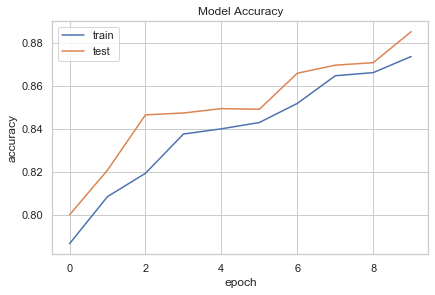

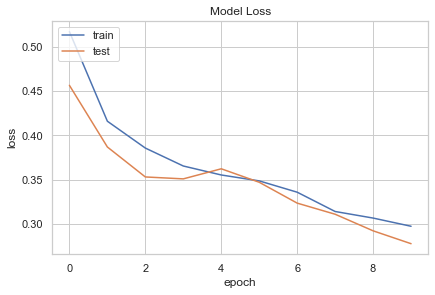

In [197]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


A possible cause of frustration when using cross-entropy with classification problems with a large number of labels is the one hot encoding process.  Sparse cross-entropy addresses this by performing the same cross-entropy calculation of error, without requiring that the target variable be one hot encoded prior to training. Using the sparse cross entropy loss function on our model with just 10 epochs gave us a stunning result with a loss score of 0.300 and an accuracy score of 0.873. With more epochs and adding more layers to the model it is possible to train this model further with better results.



# Part D - Epochs (5 points)

In terms of artificial neural networks, an epoch refers to one cycle through the full training dataset. Usually, training a neural network takes more than a few epochs. In other words, if we feed a neural network the training data for more than one epoch in different patterns, we hope for a better generalization when given a new "unseen" input (test data). An epoch is often mixed up with an iteration. Iterations is the number of batches or steps through partitioned packets of the training data, needed to complete one epoch.  Heuristically, one motivation is that (especially for large but finite training sets) it gives the network a chance to see the previous data to readjust the model parameters so that the model is not biased towards the last few data points during training.  

For our baseline model, we used 50 epochs so now we experiment with 10 epochs and see how the network plateaus.



In [180]:
def createCNNModel():
    model=Sequential()
    model.add(Convolution2D(32,5,padding = 'same',input_shape=input_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2),padding='same')) 
    model.add(Convolution2D(64,3,input_shape=input_shape,padding = 'same',activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2),strides = (2,2),padding='same'))
    model.add(Convolution2D(96,3,padding = 'same',input_shape=input_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2),strides = (2,2),padding='same'))
    model.add(Convolution2D(96,3,padding = 'same',input_shape=input_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2),strides = (2,2),padding='same'))
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(Dense(num_classes,activation='softmax'))
    return model


In [181]:
model=createCNNModel()
model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_76 (Conv2D)           (None, 100, 100, 32)      2432      
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 25, 25, 96)        55392     
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 13, 13, 96)        0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 13, 13, 96)      

In [187]:
batch_size=128
epochs=10
from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [183]:
History = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size)
# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/10
21/21 [==============================] - 59s 3s/step - loss: 1.4509 - accuracy: 0.3594 - val_loss: 1.2596 - val_accuracy: 0.4538
Epoch 2/10
21/21 [==============================] - 61s 3s/step - loss: 1.1940 - accuracy: 0.4959 - val_loss: 1.0968 - val_accuracy: 0.5780
Epoch 3/10
21/21 [==============================] - 60s 3s/step - loss: 1.1104 - accuracy: 0.5595 - val_loss: 1.0842 - val_accuracy: 0.5708
Epoch 4/10
21/21 [==============================] - 59s 3s/step - loss: 1.0410 - accuracy: 0.5885 - val_loss: 0.9340 - val_accuracy: 0.6431
Epoch 5/10
21/21 [==============================] - 61s 3s/step - loss: 0.9642 - accuracy: 0.6259 - val_loss: 0.9063 - val_accuracy: 0.6445
Epoch 6/10
21/21 [==============================] - 60s 3s/step - loss: 0.9415 - accuracy: 0.6224 - val_loss: 0.8608 - val_accuracy: 0.6705
Epoch 7/10
21/21 [==============================] - 59s 3s/step - loss: 0.9041 - accuracy: 0.6471 - val_loss: 0.9568 - val_accuracy: 0.6127
Epoch 8/10
21/21 [==

In [188]:
model.evaluate(X_test,y_test)

865/865 [==============================] - 6s 7ms/step


[1.6116435576036485, 0.18034681677818298]

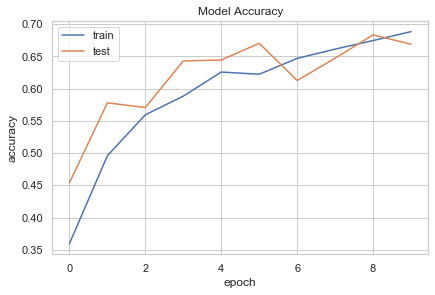

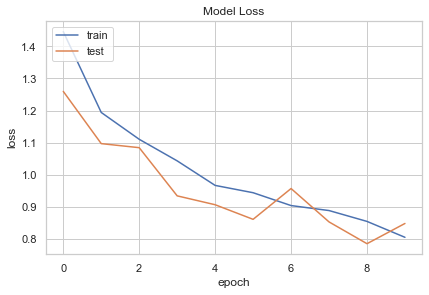

In [189]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


Our baseline model for this problem had 50 epochs which is a number that we had chosen arbitrarily. It is common practice to choose a relatively high number of epochs to get the best loss and accuracy score however, we compromise with our computation and time constraints with the high number. Here we use a relatively low number of epochs which is 10 and as expected, our results are not up to par with the loss and accuracy score of 1.611 and 0.1834.



# Part E - Gradient estimation (5 points)

Gradient descent is the preferred way to optimize neural networks and many other machine learning algorithms but is often used as a black box. Gradient descent is a way to minimize an objective function J(θ) parameterized by a model's parameters θ∈Rd by updating the parameters in the opposite direction of the gradient of the objective function 
∇θJ(θ) w.r.t. to the parameters. The learning rate η determines the size of the steps we take to reach a (local) minimum. In other words, we follow the direction of the slope of the surface created by the objective function downhill until we reach a valley.

We have used the Adam optimizer algorithm in our baseline model. (Adam) is another method that computes adaptive learning rates for each parameter. Now we use the Adagrad and the Adadelta optimizers.

Adagrad - It makes big updates for infrequent parameters and small updates for frequent parameters. For this reason, it is well-suited for dealing with sparse data.The main benefit of Adagrad is that we don’t need to tune the learning rate manually. Most implementations use a default value of 0.01 and leave it at that. Its main weakness is that its learning rate is always Decreasing and decaying.

AdaDelta - It is an extension of AdaGrad which tends to remove the decaying learning Rate problem of it. Another thing with AdaDelta is that we don’t even need to set a default learning rate.

### Using the Adagrad optimizer :-

In [199]:
batch_size=128
epochs=10
from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)
model.compile(optimizer=Adagrad(learning_rate=0.01),loss='categorical_crossentropy',metrics=['accuracy'])

In [200]:
History = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size)
# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/10
21/21 [==============================] - 61s 3s/step - loss: nan - accuracy: 0.2058 - val_loss: nan - val_accuracy: 0.1893
Epoch 2/10
21/21 [==============================] - 61s 3s/step - loss: nan - accuracy: 0.1785 - val_loss: nan - val_accuracy: 0.1893
Epoch 3/10
21/21 [==============================] - 61s 3s/step - loss: nan - accuracy: 0.1778 - val_loss: nan - val_accuracy: 0.1893
Epoch 4/10
21/21 [==============================] - 61s 3s/step - loss: nan - accuracy: 0.1816 - val_loss: nan - val_accuracy: 0.1893
Epoch 5/10
21/21 [==============================] - 61s 3s/step - loss: nan - accuracy: 0.1782 - val_loss: nan - val_accuracy: 0.1893
Epoch 6/10
21/21 [==============================] - 62s 3s/step - loss: nan - accuracy: 0.1704 - val_loss: nan - val_accuracy: 0.1893
Epoch 7/10
21/21 [==============================] - 61s 3s/step - loss: nan - accuracy: 0.1854 - val_loss: nan - val_accuracy: 0.1893
Epoch 8/10
21/21 [==============================] - 61s 3s/ste

In [201]:
model.evaluate(X_test,y_test)

865/865 [==============================] - 7s 8ms/step


[nan, 0.16763006150722504]

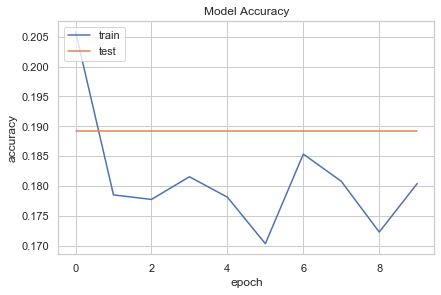

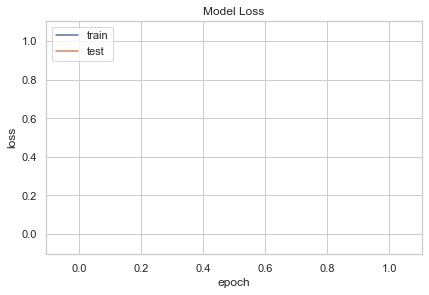

In [202]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Using the Adadelta optimizer :-

In [203]:
batch_size=128
epochs=10
from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)
model.compile(optimizer=Adadelta(learning_rate=1.0),loss='categorical_crossentropy',metrics=['accuracy'])

In [204]:
History = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size)
# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/10
21/21 [==============================] - 64s 3s/step - loss: nan - accuracy: 0.1785 - val_loss: nan - val_accuracy: 0.1893
Epoch 2/10
21/21 [==============================] - 62s 3s/step - loss: nan - accuracy: 0.1801 - val_loss: nan - val_accuracy: 0.1893
Epoch 3/10
21/21 [==============================] - 62s 3s/step - loss: nan - accuracy: 0.1778 - val_loss: nan - val_accuracy: 0.1893
Epoch 4/10
21/21 [==============================] - 62s 3s/step - loss: nan - accuracy: 0.1804 - val_loss: nan - val_accuracy: 0.1893
Epoch 5/10
21/21 [==============================] - 62s 3s/step - loss: nan - accuracy: 0.1751 - val_loss: nan - val_accuracy: 0.1893
Epoch 6/10
21/21 [==============================] - 62s 3s/step - loss: nan - accuracy: 0.1763 - val_loss: nan - val_accuracy: 0.1893
Epoch 7/10
21/21 [==============================] - 61s 3s/step - loss: nan - accuracy: 0.1740 - val_loss: nan - val_accuracy: 0.1893
Epoch 8/10
21/21 [==============================] - 61s 3s/ste

In [205]:
model.evaluate(X_test,y_test)

865/865 [==============================] - 6s 7ms/step


[nan, 0.16763006150722504]

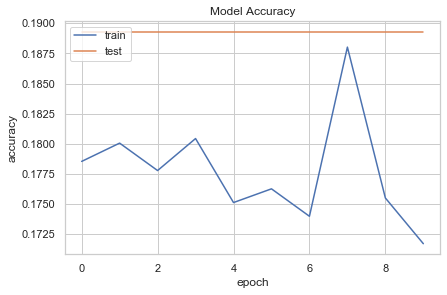

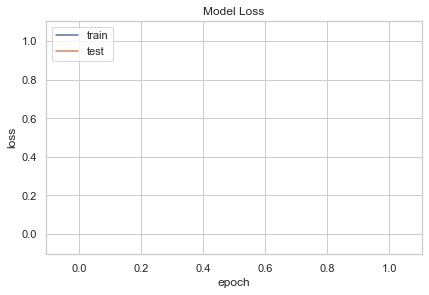

In [206]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Part F - Network Architecture (5 points)

The term neural network architecture refers to the arrangement of neurons into layers and the connection patterns between layers, activation functions, and learning methods. The neural network model and the architecture of a neural network determine how a network transforms its input into an output. This transformation is, in fact, a computation. Often, the success depends on a clear understanding of the problem, regardless of the network architecture. However, in determining which neural network architecture provides the best prediction, it is necessary to build a good model. It is essential to be able to identify the most important variables in a process and generate best-fit models. How to identify and define the best model is very controversial.

In [207]:
def createCNNModel():
    model=Sequential()
    model.add(Convolution2D(64,3,input_shape=input_shape,activation='relu'))
    
    model.add(Convolution2D(64,3,input_shape=input_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2),padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.20)) 
    
    model.add(Convolution2D(128,3,input_shape=input_shape,activation='relu'))
    
    model.add(Convolution2D(128,3,input_shape=input_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2),padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.20))
    
    model.add(Convolution2D(256,3,input_shape=input_shape,activation='relu'))
    
    model.add(Convolution2D(256,3,input_shape=input_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2),padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.20))
    
    model.add(Convolution2D(512,3,input_shape=input_shape,activation='relu'))
    
    model.add(Convolution2D(512,3,input_shape=input_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2),padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.20))
    model.add(Flatten())
    
    model.add(Dense(1000,kernel_initializer='random_uniform',activation='relu'))
    model.add(Dropout(0.20))
    
    model.add(Dense(500,kernel_initializer='random_uniform',activation='relu'))
    model.add(Dropout(0.20))
    
    model.add(Dense(num_classes,kernel_initializer='random_uniform',activation='softmax'))
    return model


In [208]:
model=createCNNModel()
model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_88 (Conv2D)           (None, 98, 98, 64)        1792      
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 96, 96, 64)        36928     
_________________________________________________________________
max_pooling2d_79 (MaxPooling (None, 48, 48, 64)        0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
dropout_16 (Dropout)         (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 46, 46, 128)       73856     
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 44, 44, 128)     

In [209]:
batch_size=128
epochs=10
from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [210]:
History = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size)
# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/10
21/21 [==============================] - 492s 23s/step - loss: 1.5636 - accuracy: 0.3878 - val_loss: 1.6331 - val_accuracy: 0.2861
Epoch 2/10
21/21 [==============================] - 488s 23s/step - loss: 1.2351 - accuracy: 0.4875 - val_loss: 1.8026 - val_accuracy: 0.2457
Epoch 3/10
21/21 [==============================] - 490s 23s/step - loss: 1.0944 - accuracy: 0.5447 - val_loss: 2.1167 - val_accuracy: 0.2413
Epoch 4/10
21/21 [==============================] - 490s 23s/step - loss: 1.0906 - accuracy: 0.5569 - val_loss: 1.8206 - val_accuracy: 0.2673
Epoch 5/10
21/21 [==============================] - 491s 23s/step - loss: 1.0584 - accuracy: 0.5671 - val_loss: 1.8032 - val_accuracy: 0.2413
Epoch 6/10
21/21 [==============================] - 503s 24s/step - loss: 1.0040 - accuracy: 0.5934 - val_loss: 2.2613 - val_accuracy: 0.2543
Epoch 7/10
21/21 [==============================] - 496s 24s/step - loss: 0.9901 - accuracy: 0.5986 - val_loss: 3.0724 - val_accuracy: 0.2413
Epoch 

In [211]:
model.evaluate(X_test,y_test)

865/865 [==============================] - 54s 63ms/step


[3.5194761866089928, 0.24971097707748413]

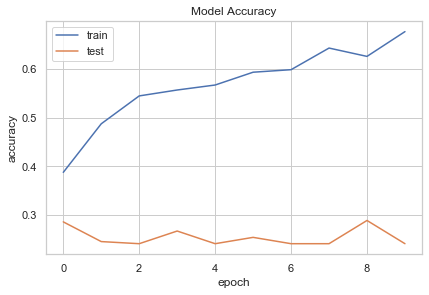

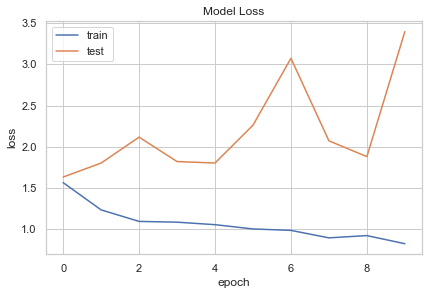

In [212]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


Changing the network architecture and adding more layers doesn't neccesarily ensure better results. Here we added more layers and different kinds of layers too but the resulting scores were not that satisfactory.



# Part G - Network initialization (5 points)

Artificial neural networks are trained using a stochastic optimization algorithm called stochastic gradient descent.
The algorithm uses randomness in order to find a good enough set of weights for the specific mapping function from inputs to outputs in your data that is being learned. It means that your specific network on your specific training data will fit a different network with a different model skill each time the training algorithm is run. Specifically, stochastic gradient descent requires that the weights of the network are initialized to small random values (random, but close to zero, such as in [0.0, 0.1]). Randomness is also used during the search process in the shuffling of the training dataset prior to each epoch, which in turn results in differences in the gradient estimate for each batch.


### Using Random Uniform network Initializer


In [213]:
def createCNNModel():
    model=Sequential()
    model.add(Convolution2D(32,5,padding = 'same',input_shape=input_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2),padding='same')) 
    model.add(Convolution2D(64,3,input_shape=input_shape,padding = 'same',activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2),strides = (2,2),padding='same'))
    model.add(Convolution2D(96,3,padding = 'same',input_shape=input_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2),strides = (2,2),padding='same'))
    model.add(Convolution2D(96,3,padding = 'same',input_shape=input_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2),strides = (2,2),padding='same'))
    model.add(Flatten())
    model.add(Dense(512,kernel_initializer='random_uniform',activation='relu'))
    model.add(Dense(num_classes,kernel_initializer='random_uniform',activation='softmax'))
    return model


In [214]:
model=createCNNModel()
model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_96 (Conv2D)           (None, 100, 100, 32)      2432      
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 25, 25, 96)        55392     
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 13, 13, 96)        0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 13, 13, 96)      

In [215]:
batch_size=128
epochs=10
from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [216]:
History = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size)
# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/10
21/21 [==============================] - 64s 3s/step - loss: 1.3950 - accuracy: 0.3548 - val_loss: 1.3551 - val_accuracy: 0.4249
Epoch 2/10
21/21 [==============================] - 62s 3s/step - loss: 1.1854 - accuracy: 0.4928 - val_loss: 1.0908 - val_accuracy: 0.5564
Epoch 3/10
21/21 [==============================] - 63s 3s/step - loss: 1.1117 - accuracy: 0.5264 - val_loss: 1.0156 - val_accuracy: 0.6171
Epoch 4/10
21/21 [==============================] - 61s 3s/step - loss: 1.0766 - accuracy: 0.5688 - val_loss: 1.0921 - val_accuracy: 0.5824
Epoch 5/10
21/21 [==============================] - 62s 3s/step - loss: 0.9827 - accuracy: 0.6141 - val_loss: 0.9408 - val_accuracy: 0.6387
Epoch 6/10
21/21 [==============================] - 62s 3s/step - loss: 0.9482 - accuracy: 0.6312 - val_loss: 0.9144 - val_accuracy: 0.6532
Epoch 7/10
21/21 [==============================] - 62s 3s/step - loss: 0.8879 - accuracy: 0.6615 - val_loss: 0.9622 - val_accuracy: 0.6171
Epoch 8/10
21/21 [==

In [217]:
model.evaluate(X_test,y_test)

865/865 [==============================] - 7s 8ms/step


[0.9129950372469907, 0.6450867056846619]

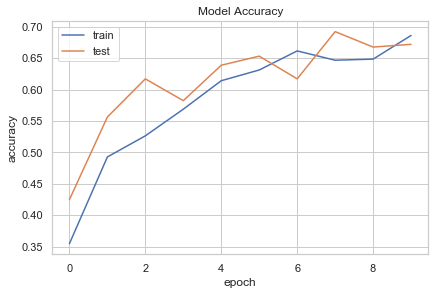

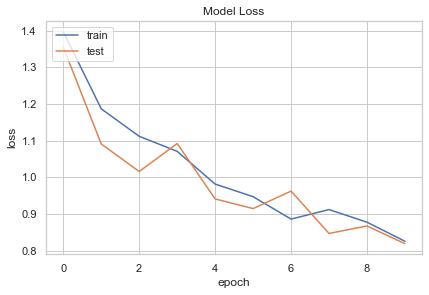

In [218]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

We use the Random Uniform network initializer first. Samples are uniformly distributed over the half-open interval low, high) (includes low, but excludes high).
Minval -  A python scalar or a scalar-tensor. Lower bound of the range of random values to generate.
Maxval - A python scalar or a scalar-tensor. Upper bound of the range of random values to generate. Defaults to 1 for float types.
Seed - A Python integer. Used to seed the random generator.

With this initializer we get the loss and accuracy scores of 0.912 and 0.645. We can see through this that the model overfit the data by a lot and that it is not the appropriate model for the data we have.

### Using Zeros now

In [219]:
def createCNNModel():
    model=Sequential()
    model.add(Convolution2D(32,5,padding = 'same',input_shape=input_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2),padding='same')) 
    model.add(Convolution2D(64,3,input_shape=input_shape,padding = 'same',activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2),strides = (2,2),padding='same'))
    model.add(Convolution2D(96,3,padding = 'same',input_shape=input_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2),strides = (2,2),padding='same'))
    model.add(Convolution2D(96,3,padding = 'same',input_shape=input_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2),strides = (2,2),padding='same'))
    model.add(Flatten())
    model.add(Dense(512,kernel_initializer='random_uniform',activation='relu'))
    model.add(Dense(num_classes,kernel_initializer='random_uniform',activation='softmax'))
    return model


In [220]:
model=createCNNModel()
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_100 (Conv2D)          (None, 100, 100, 32)      2432      
_________________________________________________________________
max_pooling2d_87 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_88 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 25, 25, 96)        55392     
_________________________________________________________________
max_pooling2d_89 (MaxPooling (None, 13, 13, 96)        0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 13, 13, 96)      

In [221]:
batch_size=128
epochs=10
from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [222]:
History = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size)
# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/10
21/21 [==============================] - 62s 3s/step - loss: 1.5189 - accuracy: 0.3271 - val_loss: 1.4041 - val_accuracy: 0.4147
Epoch 2/10
21/21 [==============================] - 62s 3s/step - loss: 1.3270 - accuracy: 0.4265 - val_loss: 1.2041 - val_accuracy: 0.5000
Epoch 3/10
21/21 [==============================] - 62s 3s/step - loss: 1.1955 - accuracy: 0.4792 - val_loss: 1.1200 - val_accuracy: 0.5275
Epoch 4/10
21/21 [==============================] - 62s 3s/step - loss: 1.0954 - accuracy: 0.5356 - val_loss: 1.0777 - val_accuracy: 0.5592
Epoch 5/10
21/21 [==============================] - 61s 3s/step - loss: 1.0418 - accuracy: 0.5796 - val_loss: 1.0288 - val_accuracy: 0.6040
Epoch 6/10
21/21 [==============================] - 62s 3s/step - loss: 1.0159 - accuracy: 0.5959 - val_loss: 1.0195 - val_accuracy: 0.6301
Epoch 7/10
21/21 [==============================] - 62s 3s/step - loss: 0.9375 - accuracy: 0.6368 - val_loss: 0.9693 - val_accuracy: 0.6127
Epoch 8/10
21/21 [==

In [223]:
model.evaluate(X_test,y_test)

865/865 [==============================] - 6s 7ms/step


[0.9254514843742282, 0.6265895962715149]

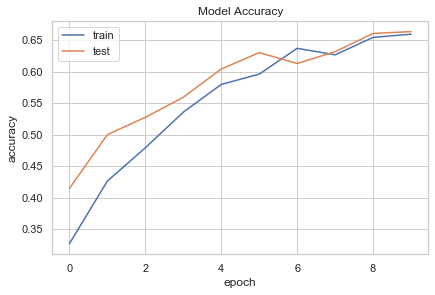

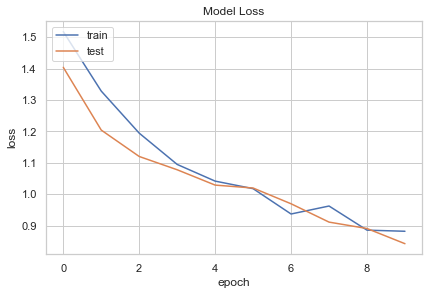

In [224]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


This initializer initializes all the filter values to zeroes. In a similar way, we can initialize all the filters with ones with One's Initializers and with constants with Constant Initializers (We can initialize with any constant values)
With the zeros initializer we get a loss and accuracy score of 0.925 and 0.626, this again means that we overfitted our data by a lot.



## Conclusion

The baseline CNN model gave us the accuracy of 78.727%, after preprocessing the images and reshaping and resizing them we got better results. The only other model that shows the potential of doing better than our baseline model with some tweaking looks to be the model that uses the Sparse cross entropy loss function that gave us an accuracy score of 87% and loss of 0.3 after just 10 epochs. With more epochs and more tweaking, the model can perform better than our baseline model does. It can also be thought of as the substitute model for this particular problem. The other models with different network architectures, loss functions, cost functions, activation functions etc overfitted the data while the accuracy didn't increase. When working with neural networks and especially cnn, there are n amount of possibilities to make our model and evaluate its performance. In this notebook, I have demonstrated few of them.

## Citations

[CNN](https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python)

[CNN](https://towardsdatascience.com/convolutional-neural-networks-for-beginners-practical-guide-with-python-and-keras-dc688ea90dca)

[Maxpooling](https://towardsdatascience.com/classification-using-neural-networks-b8e98f3a904f)

[Batch Normalization](https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c)

[Dropout regularization](https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/)

[Dense Layers](https://medium.com/@hunterheidenreich/understanding-keras-dense-layers-2abadff9b990)

[Softmax](https://deepai.org/machine-learning-glossary-and-terms/softmax-layer)

[Network Architecture](https://www.sciencedirect.com/topics/engineering/neural-network-architecture)

[Optimizers](https://www.dlology.com/blog/quick-notes-on-how-to-choose-optimizer-in-keras/)

[Epochs](https://deepai.org/machine-learning-glossary-and-terms/epoch)

[Loss Functions](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/)

[Activation Functions - 1](https://towardsdatascience.com/activation-functions-and-its-types-which-is-better-a9a5310cc8f)

[Activation Functions - 2](https://medium.com/datadriveninvestor/building-neural-network-using-keras-for-classification-3a3656c726c1)

[Image DataGen](https://medium.com/@ksusorokina/image-classification-with-convolutional-neural-networks-496815db12a8)

[Initializers](https://towardsdatascience.com/weight-initialization-techniques-in-neural-networks-26c649eb3b78)


## License


MIT License

Copyright (c) 2020 Krisha Shah

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.